# 隱含波動度濾網策略
### 摘要：
本策略參考112選擇權_評價與應用（江彌修）上課內容，結合Implied Vol.透露市場對行情的預期，建構濾網策略，協助提升選擇權演算法交易報酬。
### 估計方法與資料處理：
1. 使用TradingView會員帳號提供的調整後台指期資料作為標的資產（其價格有調整過換月合約的問題）
   （原：使用yfinance抓取台灣加權股價指數(^TWII)做為標的資產代理變數）
2. 將1.的資料與/atm_option_settle.csv 合併
3. 使用次週週選結算價判斷估計「隱含波動度」 回推：買權ATM價格=0.4* S * 買權ATM隱含波動度 *deltaT
### 操作商品與資金配置：
1. 操作商品：
   1. 台指近週選擇權，低於且最接近的期貨指數的履約價合約
   2. 進場後持有到期結算日
   3. 結算日以新合約的結算價重新進場
2. 交易口數：
   1. 口數 = 策略累積資金(金額)/250000（為控制槓桿）
   2. 初始資金: 新台幣 1,000,000。
   3. 交易成本: 交易成本+滑價成本進出共權利金3點。
   4. 回測期間: 2020/1/2 ~ 2023/8/31，共891日。
   5. 資料頻率: 日
### 策略內容：
1. 判斷次週週選之「隱含波動度」有無大於指定條件，若有則進場直到下一期的次週週選，屆時再進行一次判斷，以此類推。
2. 分別建構三種策略：
   (1) +Call (2) +Put (3) +Call+Put (4) +Call-Put (5) 大盤buy&hold
### 績效評估：
總合考量下列五指標，
   總報酬率、
   年化報酬率、
   年化波動率、
   年化夏普值、
   最大回撤(MDD)
1. +call
   1. 總報酬率: 46.97%
   2. 年化報酬率: 11.67%
   3. 年化波動率: 17.96%
   4. 年化夏普值: 0.65
   5. 最大回撤(MDD): -18.33%
2. +put
   1. 總報酬率: -40.92%
   2. 年化報酬率: -14.01%
   3. 年化波動率: 23.49%
   4. 年化夏普值: -0.6
   5. 最大回撤(MDD): -63.4%
3. +call+put
   1. 總報酬率: -11.89%
   2. 年化報酬率: -3.56%
   3. 年化波動率: 25.28%
   4.  年化夏普值: -0.14
   5.  最大回撤(MDD): -45.02%   
4. +call-put
   1. 總報酬率: 50.89%
   2. 年化報酬率: 12.52%
   3. 年化波動率: 30.56%
   4. 年化夏普值: 0.41
   5. 最大回撤(MDD): -54.67%
5.  TWII buy and hold
    1. 總報酬率: 37.47%
    2. 年化報酬率: 9.43%
    3. 年化波動率: 18.60%
    4. 年化夏普比率: 0.51
    5.  最大回撤 (MDD): -31.63%


### 研究發現：
在看多的情況下交易，+call、+call-put等濾網策略可以在績效上打敗大盤，其中+call濾網策略更是在所有的評估指標上都打敗大盤。
在(部分)看空的情況下交易，+put、+call+put等濾網策略皆無法打敗大盤。
以上結論符合預期，因濾網策略本身就是在篩選市場預期方向的策略，由於大盤長期看多，看多的濾網策略便可以篩選有用資訊，賺取報酬，而看空的濾網資訊，則無法。

In [488]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go  # 載入plotly套件
import numpy as np              # 載入numpy套件
import pandas as pd             # 載入pandas套件
import datetime as dt           # 載入datetime套件

# def fetch_prices(ticker):
#     dfs = yf.Ticker(ticker)
#     start = '2020-01-01'
#     end = '2023-09-01'
#     hist = dfs.history(start=start, end=end, interval='1d')
#     return hist

# a = fetch_prices('^TWII')
# a['Close'] = round(a['Close'], 2)
a = pd.read_csv('/Users/shawn/Github/M1/隱含波動度濾網策略/TAIFEX_DLY_TXF1!, 1D (3).csv')
a['time'] = pd.to_datetime(a['time']).dt.strftime('%Y-%m-%d')
# 保留需要的a內容，並更新欄位名稱
a['日期']  = a['time']
a['Close'] = a['close'] 
a = a[['日期','Close']]

# # 找到的
# new_data = {'日期': '2021-04-06', 'Close': 16571.28}  # Close的值用'2021-04-0x'（有值的前一期，把判斷式刪掉了）帶入
# # 将新行数据转换为DataFrame
# new_row = pd.DataFrame(new_data, index=[0])
# a = pd.concat([a, new_row]).sort_values(by='日期').reset_index(drop=True)
# print(a)

atm_df = pd.read_csv('atm_option_settle.csv')
atm_df['日期'] = pd.to_datetime(atm_df['日期'])
atm_df['日期'] = atm_df['日期'].dt.strftime('%Y-%m-%d')
print(atm_df)


             日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價
0    2020-01-02         68.0        102.0         56.0          0.1
1    2020-01-03          NaN         52.0          NaN         56.0
2    2020-01-06          NaN          5.4          NaN        147.0
3    2020-01-07          NaN          0.6          NaN        225.0
4    2020-01-08        136.0          0.1         99.0        260.0
..          ...          ...          ...          ...          ...
886  2023-08-25          NaN        167.0          NaN         67.0
887  2023-08-28          NaN        182.0          NaN         23.5
888  2023-08-29          NaN        291.0          NaN          1.3
889  2023-08-30        133.0        381.0         98.0          0.1
890  2023-08-31          NaN         82.0          NaN        131.0

[891 rows x 5 columns]


In [489]:
merged_df = pd.merge(a, atm_df, on="日期", how="inner")
merged_df

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價
0,2020-01-02,8721,68.0,102.0,56.0,0.1
1,2020-01-03,8583,NaN,52.0,NaN,56.0
2,2020-01-06,8505,NaN,5.4,NaN,147.0
3,2020-01-07,8422,NaN,0.6,NaN,225.0
4,2020-01-08,8603,136.0,0.1,99.0,260.0
...,...,...,...,...,...,...
874,2023-08-25,16531,NaN,167.0,NaN,67.0
875,2023-08-28,16663,NaN,182.0,NaN,23.5
876,2023-08-29,16762,NaN,291.0,NaN,1.3
877,2023-08-30,16659,133.0,381.0,98.0,0.1


In [490]:
merged_df['Implied volatility of Call'] = 0
merged_df['Implied volatility of Put']  = 0
for i in range(0,len(merged_df)):
    merged_df['Implied volatility of Call'][i] = merged_df['價平買權次週每日結算價'][i]/0.4/merged_df['Close'][i]/((7/365)**0.5)
    # print(merged_df['Implied volatility of Call'][i])
    merged_df['Implied volatility of Put'][i] = merged_df['價平賣權次週每日結算價'][i]/0.4/merged_df['Close'][i]/((7/365)**0.5)

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2689708188.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2689708188.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [491]:
merged_df

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價,Implied volatility of Call,Implied volatility of Put
0,2020-01-02,8721,68.0,102.0,56.0,0.1,0.140760,0.115920
1,2020-01-03,8583,NaN,52.0,NaN,56.0,NaN,NaN
2,2020-01-06,8505,NaN,5.4,NaN,147.0,NaN,NaN
3,2020-01-07,8422,NaN,0.6,NaN,225.0,NaN,NaN
4,2020-01-08,8603,136.0,0.1,99.0,260.0,0.285382,0.207741
...,...,...,...,...,...,...,...,...
874,2023-08-25,16531,NaN,167.0,NaN,67.0,NaN,NaN
875,2023-08-28,16663,NaN,182.0,NaN,23.5,NaN,NaN
876,2023-08-29,16762,NaN,291.0,NaN,1.3,NaN,NaN
877,2023-08-30,16659,133.0,381.0,98.0,0.1,0.144125,0.106198


In [492]:
merged_df['Signal of Long Call'] = 0
merged_df['Signal of Long Put'] = 0
print(merged_df['Implied volatility of Call'].mean())
print(merged_df['Implied volatility of Put'].mean())
for i in range(0,len(merged_df)):
    # if merged_df['Implied volatility of Call'][i] > merged_df['Implied volatility of Call'].mean():
    if merged_df['Implied volatility of Call'][i] > 0.3:
        merged_df['Signal of Long Call'][i] = 1 
    else:
        merged_df['Signal of Long Call'][i] = 0
    # if merged_df['Implied volatility of Put'][i] > merged_df['Implied volatility of Put'].mean():
    if merged_df['Implied volatility of Put'][i] > 0.17:
        merged_df['Signal of Long Put'][i] = 1 
    else:
        merged_df['Signal of Long Put'][i] = 0
print(merged_df['Signal of Long Put'].sum())
merged_df

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/167430465.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/167430465.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/167430465.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel

0.25352296538932817
0.17092677475550985


/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/167430465.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/167430465.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/167430465.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel

79


,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價,Implied volatility of Call,Implied volatility of Put,Signal of Long Call,Signal of Long Put
0,2020-01-02,8721,68.0,102.0,56.0,0.1,0.140760,0.115920,0,0
1,2020-01-03,8583,NaN,52.0,NaN,56.0,NaN,NaN,0,0
2,2020-01-06,8505,NaN,5.4,NaN,147.0,NaN,NaN,0,0
3,2020-01-07,8422,NaN,0.6,NaN,225.0,NaN,NaN,0,0
4,2020-01-08,8603,136.0,0.1,99.0,260.0,0.285382,0.207741,0,1
...,...,...,...,...,...,...,...,...,...,...
874,2023-08-25,16531,NaN,167.0,NaN,67.0,NaN,NaN,0,0
875,2023-08-28,16663,NaN,182.0,NaN,23.5,NaN,NaN,0,0
876,2023-08-29,16762,NaN,291.0,NaN,1.3,NaN,NaN,0,0
877,2023-08-30,16659,133.0,381.0,98.0,0.1,0.144125,0.106198,0,0


In [493]:
merged_df['Signal of Long Call_E'] = 0
merged_df['Signal of Long Put_E'] = 0
prev_value1 = 0  # 儲存上一個非NaN值的index
prev_value2 = 0  # 儲存上一個非NaN值的index

for i in range(len(merged_df)):
    if not pd.isna(merged_df['價平買權次週每日結算價'][i]):  # 檢查a['1']是否為NA
        merged_df['Signal of Long Call_E'][i] = merged_df['Signal of Long Call'][i]
        prev_value1 = i
    else:
        merged_df['Signal of Long Call_E'][i] = merged_df['Signal of Long Call'][prev_value1]
        
    if not pd.isna(merged_df['價平賣權次週每日結算價'][i]):  # 檢查a['1']是否為NA
        merged_df['Signal of Long Put_E'][i] = merged_df['Signal of Long Put'][i]
        prev_value2 = i
    else:
        merged_df['Signal of Long Put_E'][i] = merged_df['Signal of Long Put'][prev_value2]
merged_df

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2203743435.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2203743435.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2203743435.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykern

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價,Implied volatility of Call,Implied volatility of Put,Signal of Long Call,Signal of Long Put,Signal of Long Call_E,Signal of Long Put_E
0,2020-01-02,8721,68.0,102.0,56.0,0.1,0.140760,0.115920,0,0,0,0
1,2020-01-03,8583,NaN,52.0,NaN,56.0,NaN,NaN,0,0,0,0
2,2020-01-06,8505,NaN,5.4,NaN,147.0,NaN,NaN,0,0,0,0
3,2020-01-07,8422,NaN,0.6,NaN,225.0,NaN,NaN,0,0,0,0
4,2020-01-08,8603,136.0,0.1,99.0,260.0,0.285382,0.207741,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
874,2023-08-25,16531,NaN,167.0,NaN,67.0,NaN,NaN,0,0,0,0
875,2023-08-28,16663,NaN,182.0,NaN,23.5,NaN,NaN,0,0,0,0
876,2023-08-29,16762,NaN,291.0,NaN,1.3,NaN,NaN,0,0,0,0
877,2023-08-30,16659,133.0,381.0,98.0,0.1,0.144125,0.106198,0,0,0,0


In [494]:
# 測試用
# import pandas as pd
# import numpy as np

# data = {'1': [82, np.nan, np.nan, np.nan, 62, np.nan, np.nan, np.nan, 93, np.nan, np.nan, np.nan],
#         '2': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]}

# a = pd.DataFrame(data)
# a['3'] = 0

# prev_value = 0  # 儲存上一個非NaN值的index

# for i in range(len(a)):
#     if not pd.isna(a['1'][i]):  # 檢查a['1']是否為NA
#         a['3'][i] = a['2'][i]
#         prev_value = i
#     else:
#         a['3'][i] = a['2'][prev_value]

# result = a['3'].tolist()
# print(result)
# print(a)


In [495]:
merged_df.to_csv('/Users/shawn/Github/M1/價內shortPut策略程式/ck.csv')

In [496]:
# # +Call
# capital = 1000000
# # 初始化策略累積資金
# merged_df.loc[0, '策略累積資金(金額)'] = capital
# results = []
# merged_df.loc[0, '進場口數'] = 4

# for i in range(1,len(merged_df['價平買權次週每日結算價'])):
#     B = merged_df['價平買權次週每日結算價'][i - 1]
#     B1 = merged_df['Signal of Long Call_E'][i - 1]
#     C = merged_df['價平買權近週每日結算價'][i]

#     if B*B1 > 1:
#         result = round(C - B - 3 , 2)
#         merged_df['進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

#     else:
#         C_prev = merged_df['價平買權近週每日結算價'][i-1]
#         result = round(C - C_prev , 2)*B1
        
#     merged_df['進場口數'][i] = merged_df['進場口數'][i-1]
#     merged_df.loc[i, '策略累積資金(金額)'] = merged_df.loc[i-1, '策略累積資金(金額)']+result*merged_df['進場口數'][i-1]*50
    
#     results.append(result)

# results.insert(0, 0)
# print(results)
# merged_df['策略近週報酬(點數)'] = results

# # 總報酬率: 46.97%
# # 年化報酬率: 11.67%
# # 年化波動率: 17.96%
# # 年化夏普值: 0.65
# # 最大回撤(MDD): -18.33%

In [497]:
# +Put
capital = 1000000
# 初始化策略累積資金
merged_df.loc[0, '策略累積資金(金額)'] = capital
results = []
merged_df.loc[0, '進場口數'] = 4

for i in range(1,len(merged_df['價平賣權次週每日結算價'])):
    B = merged_df['價平賣權次週每日結算價'][i - 1]
    B1 = merged_df['Signal of Long Put_E'][i - 1]
    C = merged_df['價平賣權近週每日結算價'][i]

    if B*B1 > 1:
        result = round(C - B - 3 , 2)
        merged_df['進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

    else:
        C_prev = merged_df['價平賣權近週每日結算價'][i-1]
        result = round(C - C_prev , 2)*B1
        
    merged_df['進場口數'][i] = merged_df['進場口數'][i-1]
    merged_df.loc[i, '策略累積資金(金額)'] = merged_df.loc[i-1, '策略累積資金(金額)']+result*merged_df['進場口數'][i-1]*50
    
    results.append(result)

results.insert(0, 0)
print(results)
# results = [-x for x in results]
merged_df['策略近週報酬(點數)'] = results


# 總報酬率: -40.92%
# 年化報酬率: -14.01%
# 年化波動率: 23.49%
# 年化夏普值: -0.6
# 最大回撤(MDD): -63.4%

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2864482894.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2864482894.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2864482894.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipyker

[0, 0.0, 0.0, 0.0, 0.0, -73.0, -9.0, -18.5, -0.6, -0.8, -5.0, -18.0, 549.0, -55.5, 33.5, -68.1, -7.8, -70.5, 27.5, -12.0, -35.6, -8.2, -14.0, -32.0, -6.5, 76.5, -116.9, 9.0, 24.0, 116.0, -30.0, 115.0, 108.0, -133.0, -68.0, -68.5, 101.5, 239.0, -45.0, 103.0, 287.0, 317.0, 335.0, 310.0, 60.0, 277.0, -405.0, 100.0, -250.5, -9.3, -43.0, 0.0, -63.0, -56.5, -18.5, -14.6, -1.3, -13.0, -43.0, 7.0, -101.6, -4.3, -12.0, -74.5, -4.5, 62.0, -69.0, -57.0, -5.0, -53.8, -4.4, -0.7, 9.0, -90.0, -24.9, -51.0, -25.0, -27.5, -3.1, -7.3, 86.0, -63.0, 22.0, -99.0, -53.0, -49.5, 78.5, -73.0, -45.3, -6.6, 19.0, -17.0, -69.5, -15.0, -6.3, -37.0, -36.0, -15.3, -3.6, -1.0, 117.0, 80.0, 152.0, -292.0, -4.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -28.0, 74.0, -129.5, -8.5, -20.9, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -53.0, -1.5, -2.5, -40.9, -2.0, 0.0, 0.0, -0.0, 0.0, 0.0, -47.0, -34.5, -36.0, -3.2, -3.2, 319.0, -236.0, -50.0, -99.0, -37.8, 0.0, 0.0, 0.0, -0.0, 0

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2864482894.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2864482894.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2864482894.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipyker

In [498]:
# # +call+put
# capital = 1000000
# # 初始化策略累積資金
# merged_df.loc[0, '策略累積資金(金額)'] = capital
# results1 = []
# merged_df.loc[0, 'Call進場口數'] = 2
# results2 = []
# merged_df.loc[0, 'Put進場口數'] = 2

# for i in range(1,len(merged_df['價平買權次週每日結算價'])):
#     B = merged_df['價平買權次週每日結算價'][i - 1]
#     B1 = merged_df['Signal of Long Call_E'][i - 1]
#     C = merged_df['價平買權近週每日結算價'][i]

#     X = merged_df['價平賣權次週每日結算價'][i - 1]
#     X1 = merged_df['Signal of Long Put_E'][i - 1]
#     Y = merged_df['價平賣權近週每日結算價'][i]

#     if B*B1 > 1:
#         result1 = round(C - B - 3 , 2)
#         merged_df['Call進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

#     else:
#         C_prev = merged_df['價平買權近週每日結算價'][i-1]
#         result1 = round(C - C_prev , 2)*B1

#     if X*X1 > 1:
#         result2 = round(Y - X - 3 , 2)
#         merged_df['Put進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

#     else:
#         Y_prev = merged_df['價平賣權近週每日結算價'][i-1]
#         result2 = round(Y - Y_prev , 2)*X1
        
#     merged_df['Call進場口數'][i] = merged_df['Call進場口數'][i-1]
#     merged_df['Put進場口數'][i] = merged_df['Put進場口數'][i-1]
#     merged_df.loc[i, '策略累積資金(金額)'] = merged_df.loc[i-1, '策略累積資金(金額)']+result1*merged_df['Call進場口數'][i-1]*50+result2*merged_df['Put進場口數'][i-1]*50
    
#     results1.append(result1)
#     results2.append(result2)

# results1.insert(0, 0)
# results2.insert(0, 0)

# # results = [-x for x in results]
# merged_df['Call策略近週報酬(點數)'] = results1
# merged_df['Put策略近週報酬(點數)'] = results2


# 總報酬率: -11.89%
# 年化報酬率: -3.56%
# 年化波動率: 25.28%
# 年化夏普值: -0.14
# 最大回撤(MDD): -45.02%

In [499]:
# +call-put （看漲）
capital = 1000000
# 初始化策略累積資金
merged_df.loc[0, '策略累積資金(金額)'] = capital
results1 = []
merged_df.loc[0, 'Call進場口數'] = 2
results2 = []
merged_df.loc[0, 'Put進場口數'] = 2

for i in range(1,len(merged_df['價平買權次週每日結算價'])):
    B = merged_df['價平買權次週每日結算價'][i - 1]
    B1 = merged_df['Signal of Long Call_E'][i - 1]
    C = merged_df['價平買權近週每日結算價'][i]

    X = merged_df['價平賣權次週每日結算價'][i - 1]
    X1 = merged_df['Signal of Long Put_E'][i - 1]
    Y = merged_df['價平賣權近週每日結算價'][i]

    if B*B1 > 1:
        result1 = round(C - B - 3 , 2)
        merged_df['Call進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

    else:
        C_prev = merged_df['價平買權近週每日結算價'][i-1]
        result1 = round(C - C_prev , 2)*B1

    if X*X1 < 1: # 此時無做多put的訊號，視為做空put的訊號出現
        result2 = round(X - Y - 3 , 2)
        merged_df['Put進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

    else:
        Y_prev = merged_df['價平賣權近週每日結算價'][i-1]
        result2 = round(Y_prev - Y , 2)*-(X1 - 1)
        
    merged_df['Call進場口數'][i] = merged_df['Call進場口數'][i-1]
    merged_df['Put進場口數'][i] = merged_df['Put進場口數'][i-1]
    merged_df.loc[i, '策略累積資金(金額)'] = merged_df.loc[i-1, '策略累積資金(金額)']+result1*merged_df['Call進場口數'][i-1]*50+result2*merged_df['Put進場口數'][i-1]*50
    
    results1.append(result1)
    results2.append(result2)

results1.insert(0, 0)
results2.insert(0, 0)

# results = [-x for x in results]
merged_df['Call策略近週報酬(點數)'] = results1
merged_df['Put策略近週報酬(點數)'] = results2


# 總報酬率: 50.89%
# 年化報酬率: 12.52%
# 年化波動率: 30.56%
# 年化夏普值: 0.41
# 最大回撤(MDD): -54.67%

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2313590750.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2313590750.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2313590750.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipyker

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2313590750.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2313590750.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_5003/2313590750.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipyker

<Axes: >

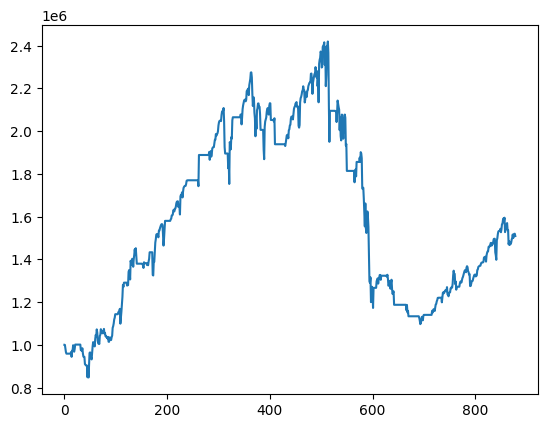

In [500]:
merged_df.to_csv('/Users/shawn/Github/M1/隱含波動度濾網策略/IV_CallPut.csv')
merged_df['策略累積資金(金額)'].plot()

In [501]:
backtest_df = merged_df
backtest_df['策略每日報酬率'] = backtest_df['策略累積資金(金額)'].pct_change()
backtest_df.loc[0, '策略每日報酬率'] = 0  # 初始化第一天策略每日報酬率

# 計算累積報酬率
backtest_df['策略累積報酬率'] = (1 + backtest_df['策略每日報酬率']).cumprod()-1
backtest_df.loc[0, '策略累積報酬率'] = 0  # 初始化第一天策略累積報酬率

# 計算Drawdown
# 計算每個時間點的最大價格
backtest_df['每個時點最大策略累積資金(金額)'] = backtest_df['策略累積資金(金額)'].cummax()
# 計算每個時間點的 Drawdown
backtest_df['Drawdown'] = (backtest_df['策略累積資金(金額)'] - backtest_df['每個時點最大策略累積資金(金額)']) / backtest_df['每個時點最大策略累積資金(金額)']
# backtest_df.to_csv('/Users/shawn/Github/M1/價內shortPut策略程式/backtest.csv')
backtest_df.head(5)

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價,Implied volatility of Call,Implied volatility of Put,Signal of Long Call,Signal of Long Put,...,進場口數,策略近週報酬(點數),Call進場口數,Put進場口數,Call策略近週報酬(點數),Put策略近週報酬(點數),策略每日報酬率,策略累積報酬率,每個時點最大策略累積資金(金額),Drawdown
0,2020-01-02,8721,68.0,102.0,56.0,0.1,0.140760,0.115920,0,0,...,4.0,0.0,2.0,4.0,0.0,0.0,0.000000,0.0000,1000000.0,0.0000
1,2020-01-03,8583,NaN,52.0,NaN,56.0,NaN,NaN,0,0,...,4.0,0.0,2.0,4.0,-0.0,-3.0,-0.000600,-0.0006,1000000.0,-0.0006
2,2020-01-06,8505,NaN,5.4,NaN,147.0,NaN,NaN,0,0,...,4.0,0.0,2.0,4.0,-0.0,-91.0,-0.018211,-0.0188,1000000.0,-0.0188
3,2020-01-07,8422,NaN,0.6,NaN,225.0,NaN,NaN,0,0,...,4.0,0.0,2.0,4.0,-0.0,-78.0,-0.015899,-0.0344,1000000.0,-0.0344
4,2020-01-08,8603,136.0,0.1,99.0,260.0,0.285382,0.207741,0,1,...,4.0,0.0,2.0,4.0,-0.0,-35.0,-0.007249,-0.0414,1000000.0,-0.0414


In [502]:
from plotly.subplots import make_subplots  #載入plotly畫子圖的套件

# 定義繪製策略損益圖方法
def draw_PnL(trace1, trace2,  title1, title2):
    
    # 打開子畫布
    fig = make_subplots(rows=2, cols=1, subplot_titles=(title1, title2), row_heights=[0.75, 0.25], shared_xaxes=True, vertical_spacing=0.1)
    
    # 帶入資料到子畫布的特定位置
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace2, row=2, col=1)
    
    # 設定子畫布共同屬性
    fig.update_layout(
        title='策略績效', # 設定圖表標題名稱
        plot_bgcolor='white', # 設定底色為白色
    )
    
    # 設定子畫布屬性
    fig.update_xaxes(row=1, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey')
    fig.update_yaxes(title_text="損益(%)", row=1, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey', zerolinecolor='darkgrey')
    fig.update_xaxes(title_text="日期", row=2, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey')
    fig.update_yaxes(title_text="損益(%)", row=2, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey', zerolinecolor='darkgrey')

    #展示圖表
    fig.show()
    
    return

In [503]:
# 建立plotly損益曲線
trace1 = go.Scatter(x=backtest_df['日期'], 
                    y=backtest_df['策略累積報酬率']*100, 
                    mode='lines', 
                    name='做空賣權策略損益', 
                    line=dict(color='blue')
                    )
trace2 = go.Scatter(x=backtest_df['日期'], 
                    y=backtest_df['Drawdown']*100, 
                    mode='lines', 
                    name='Drawdown', 
                    line=dict(color='red')
                    )

# 繪製策略損益圖
draw_PnL(trace1, trace2, '策略損益曲線', 'Drawdown')

In [504]:
# 計算績效指標
total_return = backtest_df.loc[len(backtest_df)-1, '策略累積報酬率']
annualized_return = (1+backtest_df.loc[len(backtest_df)-1, '策略累積報酬率'])**(252/len(backtest_df))-1  # 年化報酬率
annualized_volatility = np.std(backtest_df['策略每日報酬率'])*np.sqrt(252)  # 年化波動率
sharpe_ratio = annualized_return/annualized_volatility  # 年化夏普值
max_drawdown = backtest_df['Drawdown'].min()  # 最大回撤(MDD)

print("總報酬率: {}%".format(round(total_return*100,2)))
print("年化報酬率: {}%".format(round(annualized_return*100,2)))
print("年化波動率: {}%".format(round(annualized_volatility*100,2)))
print("年化夏普值: {}".format(round(sharpe_ratio,2))) 
print("最大回撤(MDD): {}%".format(round(max_drawdown*100,2)))

總報酬率: 50.89%
年化報酬率: 12.52%
年化波動率: 30.56%
年化夏普值: 0.41
最大回撤(MDD): -54.67%


[*********************100%***********************]  1 of 1 completed
總報酬率: 37.47%
年化報酬率: 9.43%
年化波動率: 18.60%
年化夏普比率: 0.51
最大回撤 (MDD): -31.63%
12100.48046875
1000000.0


<Axes: xlabel='Date'>

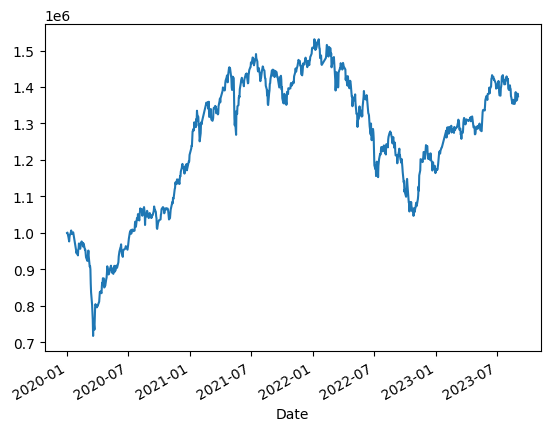

In [8]:
# 大盤Buy & Hold
import yfinance as yf
import pandas as pd
import numpy as np
def fetch_prices(ticker):
    start = '2020-01-01'
    end = '2023-09-01'
    hist = yf.download(ticker,start=start, end=end, interval='1d')
    return hist

# twii = yf.download('^TWII', start=start_date, end=end_date)
twii = fetch_prices('^TWII')

twii['Adj Close Return'] = twii['Adj Close'].pct_change() * 100  

total_return = (twii['Adj Close'][-1] / twii['Adj Close'][0] - 1) * 100

n = len(twii)  
annual_return = ((twii['Adj Close'][-1] / twii['Adj Close'][0]) ** (252 / n) - 1) * 100  

annual_volatility = twii['Adj Close Return'].std() * np.sqrt(252)

risk_free_rate = 0  
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

cumulative_return = (1 + twii['Adj Close Return'] / 100).cumprod()
peak = cumulative_return.expanding().max()
drawdown = (cumulative_return / peak - 1) * 100
max_drawdown = drawdown.min()

# 結果ˇ
print(f"總報酬率: {total_return:.2f}%")
print(f"年化報酬率: {annual_return:.2f}%")
print(f"年化波動率: {annual_volatility:.2f}%")
print(f"年化夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤 (MDD): {max_drawdown:.2f}%")

# a = twii['Adj Close'].pct_change() * 100  
# a.plot()
print(twii['Adj Close'][0])
twii['Adj Close2'] = twii['Adj Close']*(1000000/12100.48046875)
print(twii['Adj Close2'][0])
twii['Adj Close2'].plot()

# 總報酬率: 37.47%
# 年化報酬率: 9.43%
# 年化波動率: 18.60%
# 年化夏普比率: 0.51
# 最大回撤 (MDD): -31.63%